<a href="https://colab.research.google.com/github/korea2022R4720/DFE62400/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_6%EC%A1%B0_%EA%B0%9C%EC%9D%B8%ED%99%94Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split # train, test 값 분류
from sklearn.linear_model import LinearRegression, LogisticRegression # 선현회귀모델
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, tree # 의사결정나무
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, roc_curve, roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 데이터준비

In [ ]:
data = pd.read_csv("./Data/data_2019_all.txt", sep = ',', encoding= 'UTF-8', low_memory=False)

In [ ]:
data.head()

,SUCO_YM,PPNU_NO,ASSR_CS_NO,INON_NO,OGNZ_ASRT_CD,T_WY2_DANG_INP_FE,T_WY2_FUR_INS_AM,WY2_DMLO_RT,TARGET,INS_SBSN_GOOD_LRCL_CD,...,CG014_KCIS_DIG_CC_99_CC,CG014_KCIS_SROP_CC_99_CC,CG014_KCIS_HTZ_DAY_TC_99_TC,CG014_KCIS_GNTH_CNT_N03_99_CC,CG014_ENT_UNBL_CLHI_RET_YN,CG014_DAS_RET_YN,CG014_EDCT_RET_YN,predict,N,Y
0,201912,101901054218,200763491820,111568725,04,154814,0,0.0,N,1,...,0,0,84,0,N,N,N,N,0.993520,0.006480
1,201912,101901055097,200765776605,111568982,04,24805,0,0.0,N,12,...,0,4,356,0,Y,N,N,N,0.996930,0.003070
2,201912,101901055087,100901767894,111569005,01,52085,0,0.0,N,12,...,4,0,8,4,N,N,Y,N,0.994764,0.005236
3,201912,101901055147,700167552479,111569693,05,3460,0,0.0,N,1,...,0,0,0,0,N,N,N,N,0.992673,0.007327
4,201912,101901057039,200801442859,111569824,03,13464,0,0.0,N,1,...,0,0,0,0,N,N,N,N,0.998000,0.002000


In [ ]:
data.loc[data['TARGET'] =='N', 'TARGET'] = 0
data.loc[data['TARGET'] =='Y', 'TARGET'] = 1

In [ ]:
data2 = data.drop(columns = ['N','Y','predict','T_WY2_FUR_INS_AM','WY2_DMLO_RT','SUCO_YM','PPNU_NO','ASSR_CS_NO','INON_NO']) # 'percentile','PSMP_INC_AM'

In [ ]:
data2.shape

(353562, 99)

In [ ]:
data['TARGET'].value_counts()

0    345115
1      8447
Name: TARGET, dtype: int64

In [ ]:
data.groupby('INS_SBSN_GOOD_LRCL_CD').agg({'INS_SBSN_GOOD_LRCL_CD':'count','TARGET' : 'sum'})

,INS_SBSN_GOOD_LRCL_CD,TARGET
INS_SBSN_GOOD_LRCL_CD,,
1,181113,2872
5,3376,131
7,133,4
9,3738,4
10,4965,0
12,157049,5341
13,3188,95


In [ ]:
# 건강보험만 타겟팅
# data2= data2.loc[(data2['OGNZ_ASRT_CD']=='15')&(data2['INS_SBSN_GOOD_LRCL_CD']==1),:]

In [ ]:
a = pd.DataFrame(data2.dtypes)

### one-hot 인코딩

In [ ]:
data3 = pd.get_dummies(data2, columns = ['INJR_GRD_CD', 'LRCL_INS_JOB_CD','LRCL_INS_JOB_CD','COOR_WY2_GTST_RSKLVL_CD','COOR_WY3_GTST_RSKLVL_CD','WY2_GTST_RSKLVL_CD','WY3_GTST_RSKLVL_CD','CB_GRD_CD']) #'AMDL_CST_LTCH_VALU_2016','AMDL_CST_LTCH_VALU_2017','AMDL_CST_LTCH_VALU_2018'])

In [ ]:
data3.shape

(353562, 156)

### 숫자인 컬럼만 선택

In [ ]:
tp = data3.dtypes # 변수 타입 확인
test = pd.DataFrame(tp) # 판다스 형태로 변환
a = test.loc[(test[0]=='int64')|(test[0]=='uint8')|(test[0]=='float64'),:] # 숫자형 및 onehot인코딩 값 가져오기
data4 = data3.loc[:, a.index] #분석 데이터만 선택

In [ ]:
data4.shape

(353562, 174)

In [ ]:
data3.head()

,OGNZ_ASRT_CD,T_WY2_DANG_INP_FE,TARGET,INS_SBSN_GOOD_LRCL_CD,INS_SBSN_GOOD_SMCL_CD,COOR_ISRD_AG,COOR_MNNP_RTNS_CD,MNPR_ENT_AM,MNPR_INP_FE_RTO,ISTE_CN_SC_CD,...,CB_GRD_CD_02,CB_GRD_CD_03,CB_GRD_CD_04,CB_GRD_CD_05,CB_GRD_CD_06,CB_GRD_CD_07,CB_GRD_CD_08,CB_GRD_CD_09,CB_GRD_CD_10,CB_GRD_CD_ZZ
0,04,154814,0,1,10,53,1,70000000,68.03,1,...,0,0,0,0,0,0,0,0,0,1
1,04,24805,0,12,6,32,1,50000000,96.87,2,...,0,0,0,0,0,0,0,0,0,1
2,01,52085,0,12,17,35,1,55000000,85.26,99,...,0,0,0,0,0,0,0,0,0,1
3,05,3460,0,1,1,40,1,5000000,6.53,1,...,0,0,0,0,0,0,0,0,0,1
4,03,13464,0,1,10,44,3,10000000,51.50,1,...,0,0,0,0,0,0,0,0,0,1


### 학습, 테스트 데이터분리

In [ ]:
x  = data4.drop(columns = ['TARGET'])

In [ ]:
y = data4['TARGET']

In [ ]:
# X_resampled, y_resampled = sm.fit_sample(x,y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = 0.3)

In [ ]:
x_train.shape

(247493, 173)

# 언더 샘플링

In [ ]:
undersample = RandomUnderSampler()

x_resampled, y_resampled = undersample.fit_sample(x_train,y_train)

print(x_resampled.shape)
print(y_resampled.shape)

(11830, 173)
(11830,)


### SMOTE

In [ ]:
# sm = SMOTE()
# x_resampled, y_resampled = sm.fit_sample(x_train,y_train)
# x_train.shape
# x_resampled.shape
# y_resampled.shape

### 데이터 정규화(minmax스케일러)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(x_resampled)
x_train_scaled = scaler.transform(x_resampled) # SMOTE Resample 정규화

In [ ]:
x_test_scaled = scaler.transform(x_test)

# 예측 확률 함수 (분위수)

In [ ]:
def prob(model):
    proba = model.predict_proba(x_test_scaled)
    proba[:,1]
    prdict_prob = x_test
    prdict_prob['TARGET'] = y_test
    # proba = pd.DataFrame(proba)
    prdict_prob['proba'] = proba[:,1]
    # prdict_prob.to_excel('prdict_prob_randomforest.xlsx')

    prdict_prob = prdict_prob.sort_values(by = 'proba') #확률기준 정렬하기
    prdict_prob['seq'] = range(len(prdict_prob)) # 순번
    prdict_prob['flag'] = (prdict_prob['seq']/(len(prdict_prob)/10)).values # 10분위수 Decile
    prdict_prob = prdict_prob.astype({'flag': int}) # int값으로 변환
    return prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum'}) # 집계

# MLP 신경망

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (5,3), activation = 'relu', solver = 'sgd', alpha = 0.01, batch_size = 100, learning_rate_init = 0.015, max_iter= 1000)

In [ ]:
mlp.fit(x_train_scaled, y_resampled)

MLPClassifier(activation='relu', alpha=0.01, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 3), learning_rate='constant',
       learning_rate_init=0.015, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [ ]:
y_mlp_pred = mlp.predict(x_test_scaled)

In [ ]:
confusion_matrix(y_test, y_mlp_pred)

array([[73193, 30344],
       [  490,  2042]], dtype=int64)

In [ ]:
print(accuracy_score(y_test, y_mlp_pred))

0.7093024352072708


In [ ]:
prob(mlp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,seq,TARGET
flag,,
0,10607,8
1,10607,21
2,10607,40
3,10607,59
4,10607,83
5,10607,131
6,10607,182
7,10607,345
8,10607,616


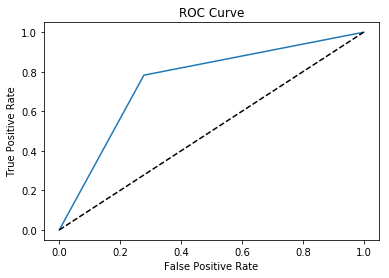

<Figure size 432x288 with 0 Axes>

In [ ]:
## ROC curve
fpr, tpr,_ = roc_curve(y_test,y_mlp_pred )
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--',color = 'black')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()

# 모델 학습

#### 의사결정나무 모델학습

In [ ]:
dtc = DecisionTreeClassifier(max_depth=5 ,random_state = 20, criterion = 'entropy')

In [ ]:
dtc.fit(x_train_scaled, y_resampled)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best')

In [ ]:
y_dtc_pred = dtc.predict(x_test_scaled)

In [ ]:
print(accuracy_score(y_test, y_dtc_pred))

0.7215680359011587


In [ ]:
confusion_matrix(y_test, y_dtc_pred)

array([[74365, 29172],
       [  361,  2171]], dtype=int64)

In [ ]:
prob(dtc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,seq,TARGET
flag,,
0,10607,4
1,10607,22
2,10607,37
3,10607,60
4,10607,61
5,10607,64
6,10607,104
7,10607,313
8,10607,773


In [ ]:
proba = dtc.predict_proba(x_test_scaled)
proba[:,1]
prdict_prob = x_test
prdict_prob['TARGET'] = y_test
prdict_prob['proba'] = proba[:,1]
# prdict_prob.to_excel('prdict_prob.xlsx')

prdict_prob = prdict_prob.sort_values(by = 'proba') #확률기준 정렬하기
prdict_prob['seq'] = range(len(prdict_prob)) # 순번
prdict_prob['flag'] = (prdict_prob['seq']/(len(prdict_prob)/10)).values # 분위수
prdict_prob = prdict_prob.astype({'flag': int}) # int값으로 변환
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum'}) # 집계

data_tmp = data[['T_WY2_FUR_INS_AM','INON_NO']]
prdict_prob = pd.merge(prdict_prob, data_tmp, left_index = True, right_index = True, how = 'left')
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum' }) # 집계
prdict_prob['profit'] = prdict_prob['T_WY2_DANG_INP_FE']-prdict_prob['T_WY2_FUR_INS_AM']
prdict_prob2 = prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum','profit':'sum' }) # 집계
prdict_prob2['ProfitByCS'] = prdict_prob2['profit']/prdict_prob2['seq']
prdict_prob2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,seq,TARGET,T_WY2_DANG_INP_FE,T_WY2_FUR_INS_AM,profit,ProfitByCS
flag,,,,,,
0,10607,11,1244029456,586743752,657285704,61967.163571
1,10607,14,1117287453,115527047,1001760406,94443.330442
2,10607,48,730745180,474580945,256164235,24150.488828
3,10607,71,522919012,627640000,-104720988,-9872.818705
4,10607,57,531824873,389777500,142047373,13391.851890
5,10607,71,565213357,645353945,-80140588,-7555.443386
6,10607,173,2445543621,502723231,1942820390,183163.985104
7,10607,251,1139715603,563186504,576529099,54353.643726
8,10607,792,1458108950,698143002,759965948,71647.586311


### 랜덤포레스트(분류)

In [ ]:
rf_classifier = RandomForestClassifier(random_state =0, max_depth = 5, min_samples_leaf = 8, min_samples_split =8, n_estimators =200)

In [ ]:
rf_classifier.fit(x_train_scaled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
rf_pred = rf_classifier.predict(x_test_scaled)

In [ ]:
rf_pred

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

In [ ]:
confusion_matrix(y_test, rf_pred)

array([[75528, 28009],
       [  445,  2087]], dtype=int64)

#### 예측확률

In [ ]:
prob(rf_classifier)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,seq,TARGET
flag,,
0,10607,15
1,10607,26
2,10607,40
3,10607,43
4,10607,68
5,10607,74
6,10607,138
7,10607,336
8,10607,698


In [ ]:
proba = rf_classifier.predict_proba(x_test_scaled)
proba[:,1]
prdict_prob = x_test
prdict_prob['TARGET'] = y_test
prdict_prob['proba'] = proba[:,1]
# prdict_prob.to_excel('prdict_prob.xlsx')

prdict_prob = prdict_prob.sort_values(by = 'proba') #확률기준 정렬하기
prdict_prob['seq'] = range(len(prdict_prob)) # 순번
prdict_prob['flag'] = (prdict_prob['seq']/(len(prdict_prob)/10)).values # 분위수
prdict_prob = prdict_prob.astype({'flag': int}) # int값으로 변환
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum'}) # 집계

data_tmp = data[['T_WY2_FUR_INS_AM','INON_NO']]
prdict_prob = pd.merge(prdict_prob, data_tmp, left_index = True, right_index = True, how = 'left')
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum' }) # 집계
prdict_prob['profit'] = prdict_prob['T_WY2_DANG_INP_FE']-prdict_prob['T_WY2_FUR_INS_AM']
prdict_prob2 = prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum','profit':'sum' }) # 집계
prdict_prob2['ProfitByCS'] = prdict_prob2['profit']/prdict_prob2['seq']
prdict_prob2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,seq,TARGET,T_WY2_DANG_INP_FE,T_WY2_FUR_INS_AM,profit,ProfitByCS
flag,,,,,,
0,10607,15,343938191,337976603,5961588,562.042802
1,10607,26,696395763,307643707,388752056,36650.519091
2,10607,40,719072929,473264585,245808344,23174.162723
3,10607,43,1010413080,916361226,94051854,8866.960875
4,10607,68,1620622509,487692687,1132929822,106809.637221
5,10607,74,1293092669,441574038,851518631,80278.931932
6,10607,138,1281693338,398674793,883018545,83248.660790
7,10607,336,1371739221,600077986,771661235,72750.187141
8,10607,698,1883737439,618915500,1264821939,119244.078344


#### 변수 중요도

In [ ]:
importance = rf_classifier.feature_importances_ # 변수 중요도
feature = x_train.columns # 변수 중요도 컬럼명 
importances = pd.DataFrame() 
importances['feature'] = feature
importances['importances'] = importance

importances.sort_values('importances', ascending = False, inplace = True)

In [ ]:
importances.head(10)

,feature,importances
16,TRTY_CC,0.133584
0,T_WY2_DANG_INP_FE,0.121812
12,PMPE_TC,0.099647
6,MNPR_INP_FE_RTO,0.073989
8,ISTE_CN_DVVA,0.070432
11,PMPE_TC_DVVA,0.068237
9,ISTE_CN,0.062482
17,SLN_CHNN_SC_CD,0.032112
1,INS_SBSN_GOOD_LRCL_CD,0.031458
7,ISTE_CN_SC_CD,0.028451


#### 로지스틱 회귀분석

In [ ]:
model_logit = LogisticRegression()

In [ ]:
model_logit.fit(x_train_scaled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
model_logit_pred = model_logit.predict(x_test_scaled)

In [ ]:
accuracy_score(y_test, model_logit_pred)

0.7621831072226569

In [ ]:
confusion_matrix(y_test, model_logit_pred)

array([[79034, 24503],
       [  722,  1810]], dtype=int64)

In [ ]:
prob(model_logit)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,seq,TARGET
flag,,
0,10607,9
1,10607,38
2,10607,54
3,10607,53
4,10607,92
5,10607,141
6,10607,190
7,10607,335
8,10607,579


In [ ]:
proba = model_logit.predict_proba(x_test_scaled)
proba[:,1]
prdict_prob = x_test
prdict_prob['TARGET'] = y_test
prdict_prob['proba'] = proba[:,1]
# prdict_prob.to_excel('prdict_prob.xlsx')

prdict_prob = prdict_prob.sort_values(by = 'proba') #확률기준 정렬하기
prdict_prob['seq'] = range(len(prdict_prob)) # 순번
prdict_prob['flag'] = (prdict_prob['seq']/(len(prdict_prob)/10)).values # 분위수
prdict_prob = prdict_prob.astype({'flag': int}) # int값으로 변환
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum'}) # 집계

data_tmp = data[['T_WY2_FUR_INS_AM','INON_NO']]
prdict_prob = pd.merge(prdict_prob, data_tmp, left_index = True, right_index = True, how = 'left')
# prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum' }) # 집계
prdict_prob['profit'] = prdict_prob['T_WY2_DANG_INP_FE']-prdict_prob['T_WY2_FUR_INS_AM']
prdict_prob2 = prdict_prob.groupby(['flag']).agg({'seq':'count', 'TARGET':'sum', 'T_WY2_DANG_INP_FE':'sum', 'T_WY2_FUR_INS_AM': 'sum','profit':'sum' }) # 집계
prdict_prob2['ProfitByCS'] = prdict_prob2['profit']/prdict_prob2['seq']
prdict_prob2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,seq,TARGET,T_WY2_DANG_INP_FE,T_WY2_FUR_INS_AM,profit,ProfitByCS
flag,,,,,,
0,10607,9,891120904,575610000,315510904,29745.536344
1,10607,38,708622734,395991252,312631482,29474.072028
2,10607,54,775230590,417043135,358187455,33768.969077
3,10607,53,889535289,611920812,277614477,26172.761101
4,10607,92,976458430,456726630,519731800,48998.944094
5,10607,141,1033995822,429238634,604757188,57014.913548
6,10607,190,1126976193,526862158,600114035,56577.169322
7,10607,335,1226174369,557721578,668452791,63019.967097
8,10607,579,1771288072,669296954,1101991118,103892.817762


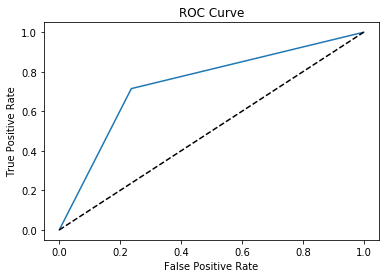

<Figure size 432x288 with 0 Axes>

In [ ]:
## ROC curve
fpr, tpr,_ = roc_curve(y_test,model_logit_pred )
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--',color = 'black')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()

In [ ]:
roc_auc_score(y_test,model_logit_pred )

0.7390952812604286

#### KNN

In [ ]:
# model_kn = KNeighborsClassifier(n_neighbors = 5)
# model_kn.fit(x_train_scaled, y_resampled)
# model_kn_pred = model_kn.predict(x_test_scaled)
# confusion_matrix(y_test, model_kn_pred)
# prob(model_kn)

### SVM

In [ ]:
clf = SVC(kernel = 'linear', C = 1.0)

In [ ]:
clf.fit (x_train_scaled, y_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
model_svc_pred = clf.predict(x_test_scaled)

In [ ]:
confusion_matrix(y_test, model_svc_pred)

array([[78643, 24894],
       [  688,  1844]], dtype=int64)

# 앙상블

In [ ]:
single_models = [
    ('MLP', mlp),
#     ('logistic',model_logit ), 
    ('randomforest',rf_classifier), 
    ('tree', dtc), 
#     ('svc', clf)
]

In [ ]:
voting_classifier = VotingClassifier(single_models, n_jobs = -1)

In [ ]:
voting_classifier.fit(x_train_scaled, y_resampled)

VotingClassifier(estimators=[('MLP', MLPClassifier(activation='relu', alpha=0.01, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 3), learning_rate='constant',
       learning_rate_init=0.015, max_iter=1000, momentum=0.9,
       nesterovs_momentum=T...        min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [ ]:
model_voting_pred = voting_classifier.predict(x_test_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
confusion_matrix(y_test, model_voting_pred)

array([[79584, 23953],
       [  478,  2054]], dtype=int64)

In [ ]:
accuracy_score(y_test, model_voting_pred)

0.7696688004977892